# Исследование продаж видео-игр

Интернет-магазине **«Стримчик»**, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, _Xbox_ или _PlayStation_).

Необходимо выявить закономерности, определяющие **успешность игры**. Это позволит сделать ставку на потенциально популярный продукт и спланировать **рекламные кампании**.

Исходные данные представляют из себя перечень игр с ключевыми характеристиками: жанр, год издания, рейтинг и т.д. Информация о количестве продаж собрана до 2016 год, включительно. Информация за 2016-ый год может быть не полной. Данные из открытых источников.

В наборе данных попадается аббревиатура [ESRB](https://www.esrb.org/) (_Entertainment Software Rating Board_) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. _ESRB_ оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**План работы:**
1. [Чтение и знакомство с данными.](#section_1)
2. [Предобработка данных.](#section_2)
3. [Дополнение информации для последующего анализа.](#section_3)
4. [EDA. Графическое отображение результатов.](#section_4)
5. [Проверка гипотез.](#section_5)
6. [Общий вывод по поставленной задаче.](#section_6)

<a id='section_1'></a>
# 1. Исходные данные и общая информация

In [1]:
import pandas as pd
import seaborn as sns

from scipy import stats as st
from matplotlib import pyplot as plt

In [2]:
try:
    try:
        data = pd.read_csv('datasets\games.csv') #домашняя версия
    except:
        data = pd.read_csv('/datasets/games.csv') #сетевая версия
    display(data.head())
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Описание данных**:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации [ESRB](https://www.esrb.org/) (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [3]:
data.info()
original_lengthe_df = data.shape[0] #сохранение исходной длинны DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


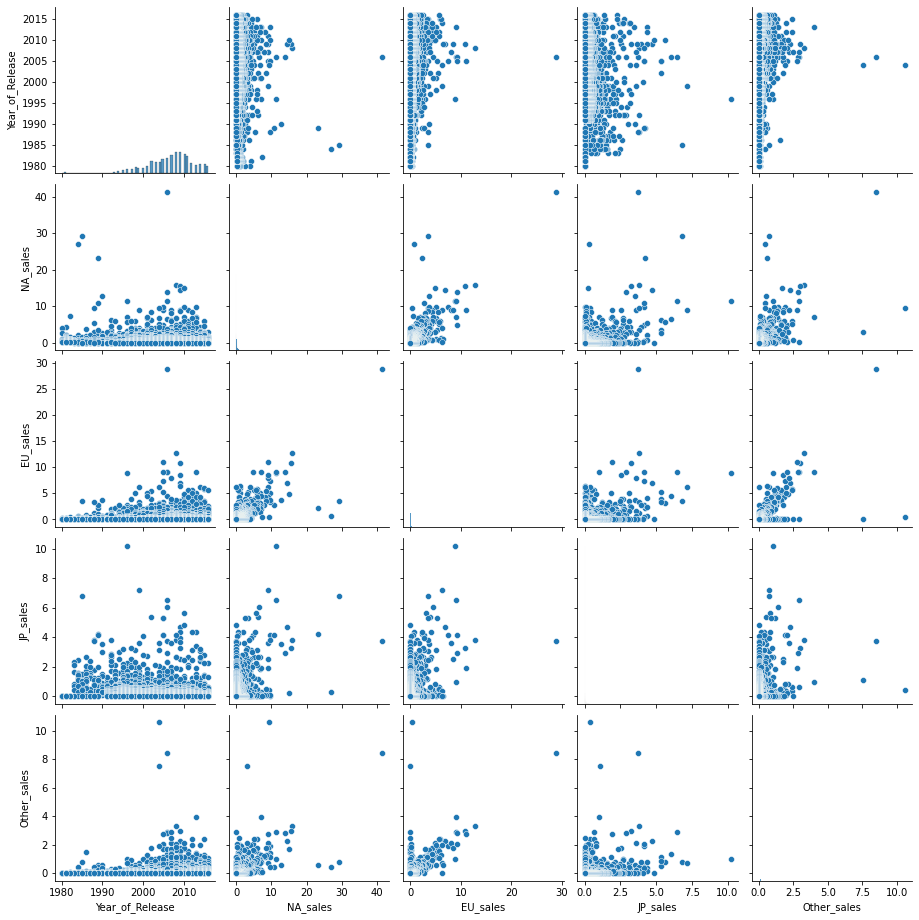

In [4]:
sns.pairplot(data[['Year_of_Release', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales']])
plt.gcf().set_size_inches(13,13);

In [5]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Доля пропусков в колонках датафрейма (значения в %)' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось')

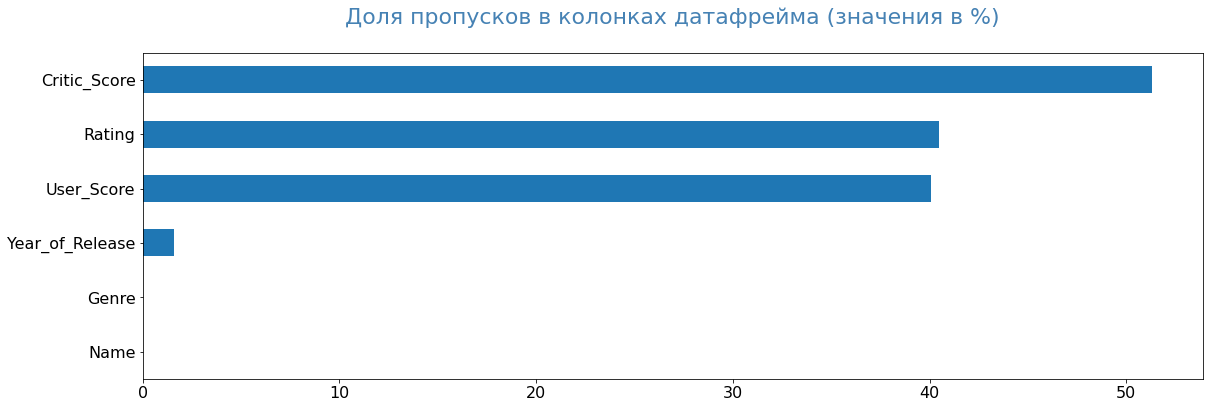

In [6]:
pass_value_barh(data)

<a id='section_2'></a>
# 2. Подготовка данных

Краткое описание надостатков данных и способов их исправления. Датафрэйм содержит всего **16715** записей и **11** колонок.

[Устранить **пропуски**](#section_2_1) с учётом типа данных. Пояснить, причину заполнение пропусков определённым образом и значением. Описать возможную причину появления пропусков.
Обратить внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разобрать это значение и описать, как его обработать.
- [категориальные](#section_2_1): `Name`, `Genre`, `Rating`.
- [количественные](#section_2_2): `User_Score`, `Critic_Score`.

[Сменить **тип данных**](#section_2_3), на тот что им соответствует:
- datetime <- `Year_of_Release`;
- float <- `User_Score`;
- int <- `Critic_Score`.

Следует перезаписать **название** в едином формате _змеиный_регистр_.

In [7]:
data.columns = data.columns.str.lower() #переименовывание столбца

<a id='section_2_1'></a>
## 2.1 Пропуски в категориальных данных

### `name` - название видеоигр

**Пропусков** в этой колонке немного, всего 2: безымянные игры 93-го года публикации без жанра, оценок и рейтинга. Ввиду этого - эти игры не смогут привнести что-либо значимого в процесс оценки успешных жанров или платформ. Их можно удалить. Это не приведёт к уменьшению точности исследования или значительному уменьшению общей выборки.

Игры продавались преимущественно на одной территории, и не пользовались сравнительно большой популярностью. Одна из них имеет небольшие продажи исключительно на территории Японии.

In [8]:
# удаление безымянных игр (2 ед.)
data = data.dropna(subset=['name'])
data = data.reset_index(drop=True)

Удаление **пробелов** в начале и конце название игры. Замена слов на общепринятые сокращения.
Добавить знаки препинания, там где их не хватает, к примеру: `007 Racing` и `007: Quantum of Solace`.

Пусть не смущает названия начинающихся с `.hack//`- такое имя носит целая серия видеоигра.

In [9]:
data['name'] = data['name'].str.strip()

befor = ['007 Racing', 'Ace Combat 04: Shattered Skies', "Agatha Christie's The ABC Murders", 'versus']
after = ['007: Racing', 'Ace Combat 4: Shattered Skies', 'Agatha Christie: The ABC Murders', 'vs']

for id in range(len(befor)):
    data['name'] = data['name'].replace(befor[id], after[id])

**Явные дубликаты** - отсутствуют.

In [10]:
data.duplicated().sum()

0

**Неявные дубликаты** присутствуют в огромном количестве. Некоторые игры записаны дважды. Дублирующая запись имеет особую отметку в названии игры. Эта отметка поясняет о каком типе продаж идёт речь. К примеру: `jp sales` (продажи в Японии), и подобные. В результате сведения о продаже одной игры разбиты на две отдельные записи.

In [11]:
# особые отметки в названиях игр, выловленные вручную с помощью функции, описанной ниже
marks = ['(JP sales)', '(JP Sales)', '(jp sales)', '(old JP sales)', '(Japan Sales)', '(higher JP sales)',
         '(JP weekly sales)', '(weekly JP sales)', '(weekly jp sales)', '(JP & Others sales)', '(JP & incomplete US sales)',
         '(US sales)', '(US Sales)', '(us sales)', '(old US sales)', '(American Sales)', '(American sales)',
         '(US weekly sales)', '(correct US sales)', '(America weekly sales)', '(Weekly american sales)',
         '(American and Others sales)', '(US & Others sales)',
         '(All Region sales)', '(All region sales)', '(all regions sales)', '(Old all region sales)', '(Others sales)']

def find_marked_name(marks_list): # аргумент - список искомых меток
    marked_names = [] # список названий с найденными отметками
    unmarked_names = []
    for mark in marks_list:
        for name in sorted(data['name'].unique()):
            if name.find(mark) >= 0: # если в названии игры обнаруживается отметка, то:
                marked_names.append(name)
                unmarked_names.append(name[0:-(len(mark)+1)]) # перечень игр, среди которых встречаются дубликаты
    return data[data['name'].isin(marked_names)] # вывод - строки датафрейма с играми имеющие отметки.

Две игры имеющие недостоверные данные о продажах. Об этом говорят отметки в их названии: `(JP sales, but wrong system)` и `(sales, but wrong system)`

In [12]:
display(find_marked_name(['(JP sales, but wrong system)', '(sales, but wrong system']).sort_values(by='name'))
data = data.drop(index = find_marked_name(['(JP sales, but wrong system)', '(sales, but wrong system)']).index)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8999,"Lunar 2: Eternal Blue(sales, but wrong system)",GEN,1994.0,Role-Playing,0.0,0.0,0.14,0.0,NaN,NaN,NaN
16151,Pachi-Slot Teiou: Golgo 13 Las Vegas (JP sales...,PS2,2002.0,Misc,0.0,0.0,0.01,0.0,NaN,NaN,NaN


In [13]:
display(data[(data['name']=='Ape Escape Academy') | (data['name']=='Ape Escape Academy (jp sales)')])

data.loc[data['name']=='Ape Escape Academy', 'jp_sales'] = \
    data.loc[data['name']=='Ape Escape Academy (jp sales)', 'jp_sales'].values

data = data.drop(index=data[data['name']=='Ape Escape Academy (jp sales)'].index)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5454,Ape Escape Academy,PSP,2004.0,Misc,0.13,0.15,0.00,0.05,51.0,5.8,E10+
9248,Ape Escape Academy (jp sales),PSP,2004.0,Misc,0.00,0.00,0.13,0.00,NaN,NaN,NaN


#Для этой ячейки намеренно был изменён тип на: Markdown, дабы не исполнялся отрезок кода.
#Попытка произвести лемматизацию:

#серии видеоигра / игровые франшизы. Исключение дублирования по игровым платформам.
game_series = data.groupby('name', as_index=False)['platform'].count()

for i in range(game_series.shape[0]):
    game_series.loc[i,'short_name'] = str(game_series.loc[i, 'name'])[0:10] #выделение однокоренных названий

game_series = game_series[game_series['short_name'].duplicated()].sort_values(by='name').reset_index(drop=True)
display(game_series)

Устранение дублирование в названии игры "**Adventure Time: The Secret of the Nameless Kingdom**" и её продажах. На эту ошибку наткнулся случайно в процессе визуального осмотра исходных данных.

In [14]:
display(data[data['name']=='Adventure Time: The Secret of the Nameless Kingdom'])
display(data[data['name']=='Adventure Time: The Secret of the Nameless'])

data.loc[(data['name']=='Adventure Time: The Secret of the Nameless Kingdom') & (data['platform']=='3DS'), 'na_sales'] = \
    data.loc[(data['name']=='Adventure Time: The Secret of the Nameless') & (data['platform']=='3DS'), 'na_sales'].values
data.loc[(data['name']=='Adventure Time: The Secret of the Nameless Kingdom') & (data['platform']=='X360'), 'na_sales'] = \
    data.loc[(data['name']=='Adventure Time: The Secret of the Nameless') & (data['platform']=='X360'), 'na_sales'].values

data = data[data['name'] != 'Adventure Time: The Secret of the Nameless']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11435,Adventure Time: The Secret of the Nameless Kin...,3DS,2014.0,Action,0.0,0.07,0.0,0.0,65.0,5.6,E10+
12640,Adventure Time: The Secret of the Nameless Kin...,X360,2014.0,Action,0.0,0.05,0.0,0.0,58.0,7.5,E10+


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16008,Adventure Time: The Secret of the Nameless,3DS,2014.0,Adventure,0.01,0.0,0.0,0.0,NaN,NaN,NaN
16292,Adventure Time: The Secret of the Nameless,X360,2014.0,Adventure,0.01,0.0,0.0,0.0,NaN,NaN,NaN


_Примечание:_ На этапе **3.2**, при более детальном знакомстве с данными была обнаружена **аномалия** для `Nintendo DS`. Игровая приставка была выпущена в 2004 году, а аномальная игра в 1985, что соответственно не сходится. Причина такого происшествия, оказалось в том, что игра `Strongest Tokyo University Shogi` была действительно выпушена в 1985 году, а её версия для Nintendo DS была адаптирована 2010.

In [15]:
display(data[(data['platform'] == 'DS') & (data['year_of_release'] < 2004)])
data.loc[(data['platform'] == 'DS') & (data['year_of_release'] < 2004), 'year_of_release'] = 2010
display(data[data['name'] == 'Strongest Tokyo University Shogi DS'])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15955,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15955,Strongest Tokyo University Shogi DS,DS,2010.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


### `platform` - игровые платформы

Неявные дубликаты - отсутствуют. Все уникальные значения - являются таковыми, и представляют из себя сокращения или  аббревиатуры названий платформ.

In [16]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

### `genre` - игровые жанры

Неявные дубликаты - отсутствуют. От пропусков можно избавиться 2мя вариантами: жанры могут быть заполнены вручную на актуальные данные, дабы не вносить искажения. Но т.к. это трудоёмкий процесс, встаёт вопрос о целесообразности потраченного времени. Альтернативный вариант: замена пропущенных жанров на значение 'unnamed_genre' - если возникнет такая необходимость.

In [17]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

<a id='ESRB'></a>
### `rating` - рейтинг игр

В наборе данных попадается аббревиатура [ESRB](https://www.esrb.org/). Это ассоциация оценивает игровой контент и присваивает ему подходящую возрастную категорию, например: «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [18]:
print(data['rating'].unique())
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'
data['rating'] = data['rating'].fillna('no_rating') #UPD
print(data['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
['E' 'no_rating' 'M' 'T' 'E10+' 'AO' 'EC' 'RP']


Расшифровка (в порядке увеличения возростной группы):
- `EC` («Early childhood») — «Для детей младшего возраста»
- `E` («Everyone») — «Для всех» (`K-A` - старое обозначение)
- `E10+` («Everyone 10 and older») — «Для всех от 10 лет и старше»
- `T` («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет.
- `M` («Mature») — «Для взрослых» 
- `AO` («Adults Only 18+») — «Только для взрослых» 
- `RP` («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в _ESRB_ и ожидает присвоения рейтинга.

**Пропуски** в колонке являются случайными ошибками, в своём большинстве. При проверке наличия возрастного рейтинга, **вручную**, оказалось, что для замена пропусков нельзя выбрать одно конкретное значение. Все игры имеют разный рейтинг, и самый точный способ подбора значения на замену будет по названию. Либо, дествительно использовать заглушку `no_rating`.

**Исключением** является группы японских игр, для отображения продаж которых, используется отдельная строка ДФ с отметкой `jp sales` (или подобной). В этом случае проблему строит решать, не заглушкой, а искать основную строку этой игры, и дополнять её японскими продажами. Как правило, в этой же строке присутствуют все оценки и рейтинги.

Я посещал **сайт** этой ассоциации. Хоть ESRB в первую очередь предназначена для США и Канады, но она получила распространение далеко за пределы Северной Америки. Фирменные рейтинговые логотипы нередко попадались на глаза даже на территории России. В поддержку этому добавлю выдержка с оф. сайта, раздел "About":
- The result is a rating system that is widely adopted by game publishers, supported by retailers, regularly used by parents, and consistently described by regulators and opinion leaders as the most effective entertainment rating system in the U.S., if not the world.

<a id='section_2_2'></a>
## 2.2 Пропуски в количественных данных

<a id='tbd'></a>
### `user_score` - оценки игроков

In [19]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В этом столбце встречается значение **tbd**. Таких строк около 2400 шт. Эта аббревиатура может расшифровываться как: "To Be Determined" - "Будет определено", т.е. игру ещё предстоит оценить (если она новая), или оценки пользователей требуется собрать воедино и произвести подсчёт.

Чтобы заменить эти значения, необходимо обратиться к источнику этих данных за обновлёнными оценками. С течением времени, расчёт оценки для некоторых игр мог быть завершен. Если оценка игры по прежнему остаётся в статусе "To Be Determined", вероятно для расчёта нет достаточного количества значений и её оценка не может считаться достоверной.

In [20]:
data[data['user_score'] == 'tbd'] 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16693,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16695,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16696,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16702,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


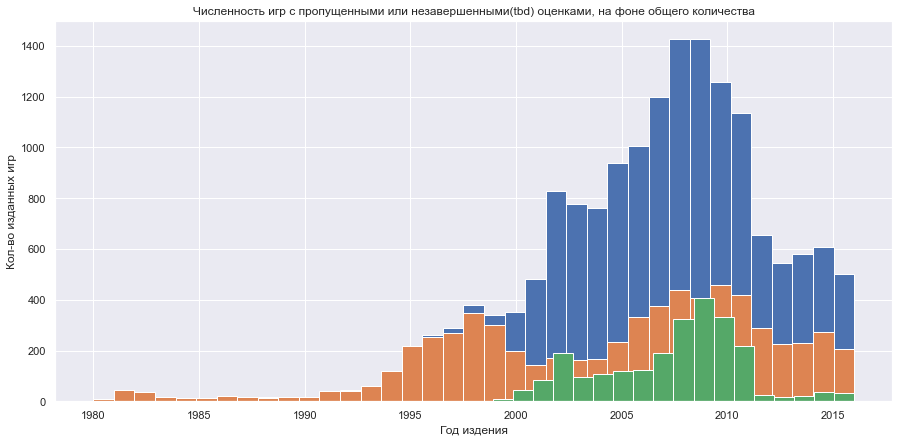

In [21]:
sns.set(rc = {'figure.figsize':(15,7)}) #UPD

data['year_of_release'].hist(bins=37)
data.loc[data['user_score'].isna(), 'year_of_release'].hist(bins=37)
data.loc[data['user_score']=='tbd', 'year_of_release'].hist(bins=20)

plt.title('Численность игр с пропущенными или незавершенными(tbd) оценками, на фоне общего количества') #UPD
plt.ylabel('Кол-во изданных игр')
plt.xlabel('Год издения');

Заполнение пропусков в оценках искуственными данными может повлечь сильные искажения, т.к. их доля велика - 59% Дабы сохранить достоверность исходных данных, замена производиться не будет. Взамен этого лучше запросить обновлённые оценки, о которых шла речь выше, и таким образом, увеличить выборку.

Такая массовость пропуском может говорить о систематичной ошибке. Возможно, некоторые ресурсы, с которых собирались данные используют другую систему оценок (отличной от 100 бальной), и их значения ошибочно заменили пропусками.

In [22]:
print(data.loc[~data['user_score'].isna(), 'user_score'].count() / original_lengthe_df)

0.5991026024528866


**Заведомо ложные оценки** (отрицательные или свыше 10 баллов)  - отсутствуют

In [23]:
numerical_user_score = data.loc[(data['user_score'] != 'tbd') & (~data['user_score'].isna()), 'user_score'].astype('float')
numerical_user_score[(numerical_user_score < 0) | (numerical_user_score > 10)].count()

0

### `critic_score` - оценки критиков

In [24]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Заведомо ложные оценки (отрицательные или свыше 100 баллов)  - отсутствуют

In [25]:
data.loc[(data['critic_score'] < 0) | (data['critic_score'] > 100), 'critic_score'].count()

0

<a id='year_of_release'></a>
### `year_of_release` - год издания игры

In [26]:
nan_data = data[(data['year_of_release'].isna()) & (data['critic_score'].isna()) & (data['user_score'].isna())]
display(nan_data)
data = data.drop(index = nan_data.index) #UPD

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,no_rating
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,no_rating
1300,Triple Play 99,PS,NaN,Sports,0.81,0.55,0.00,0.10,NaN,NaN,no_rating
1505,Adventure,2600,NaN,Adventure,1.21,0.08,0.00,0.01,NaN,NaN,no_rating
1584,Combat,2600,NaN,Action,1.17,0.07,0.00,0.01,NaN,NaN,no_rating
...,...,...,...,...,...,...,...,...,...,...,...
16077,Football Manager 2007,X360,NaN,Sports,0.00,0.01,0.00,0.00,NaN,NaN,no_rating
16291,AKB1/48: Idol to Guam de Koishitara...,X360,NaN,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no_rating
16327,Brothers in Arms: Furious 4,X360,NaN,Shooter,0.01,0.00,0.00,0.00,NaN,NaN,M
16346,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,no_rating


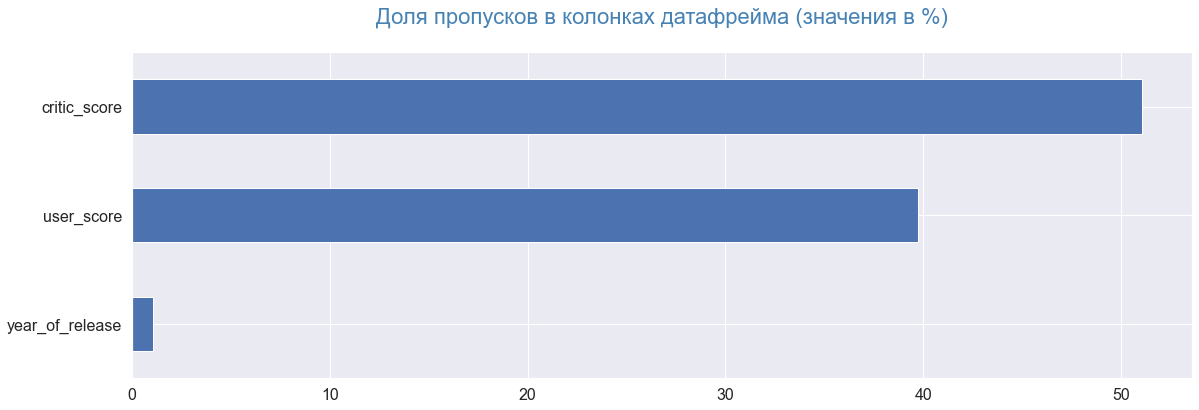

In [27]:
pass_value_barh(data) #Итоговый контроль

<a id='section_2_3'></a>
## 2.3 Изменение типов данных

Сменить **тип**, исходя из содержания данных, на более соответствующий:
- `year_of_release` - содержит дату издания игры, чему соответствует тип `datetime`, но если учесть, что из даты указан только год, то можно использовать тип `int`. Это позволит избежать бессмысленного повторения _1ого января_ в каждой строке.
- `critic_score` - содержат оценки по 100 больной шкале, т.е. только целочисленные значения `int`;
- `user_score` - содержит оценки по 10-ти бальной шкале, т.е. десятичные дробные значений `float`.

In [28]:
for col in ['critic_score', 'year_of_release']:
    data[col] = data[col].astype('Int64')

data.info() #Контроль типов данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16619 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16619 non-null  object 
 1   platform         16619 non-null  object 
 2   year_of_release  16439 non-null  Int64  
 3   genre            16619 non-null  object 
 4   na_sales         16619 non-null  float64
 5   eu_sales         16619 non-null  float64
 6   jp_sales         16619 non-null  float64
 7   other_sales      16619 non-null  float64
 8   critic_score     8137 non-null   Int64  
 9   user_score       10014 non-null  object 
 10  rating           16619 non-null  object 
dtypes: Int64(2), float64(4), object(5)
memory usage: 1.6+ MB


<a id='section_2_2'></a>
## 2.4 Дополнительной подсчёт

Cуммарные продажи во всех регионах в отдельном столбце.

In [29]:
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
display(data.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,no_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,no_rating,31.38


<a id='section_3'></a> 
# 3. Исследовательский анализ данных

В этом разделе поочерёдно разбирается ряд обязательных вопросов, сформулированных загазчиком.

## 3.1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

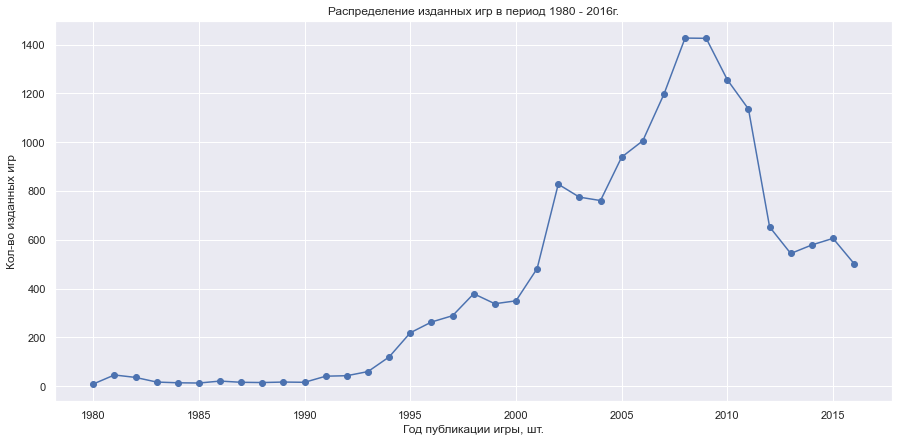

In [30]:
games_per_year = data.groupby('year_of_release')['name'].count().to_frame().reset_index()
games_per_year.plot(style='o-', x='year_of_release', y='name', grid=True, legend=False, figsize=(15,7),
                    title='Распределение изданных игр в период 1980 - 2016г.',
                    xlabel='Год публикации игры, шт.', ylabel='Кол-во изданных игр');

Из всего периода стоит взять отрезок **2013-2016**г. (ориентировочно 3,5 года). Он содержит наиболее актуальные данные, которые **близко** расположены к прогнозируемому 2017 году. Помимо этого, каждый год из этого отрезка имеет практически **одинаковую выборку** по играм, что позволит их сравнивать между собой.

Остальные данные (игры, платформы, жанры) притерпели **значительные изменения** с 80-ых годов до текушего времени. За этот период изменилась аудитория, технические возможности платформ, а также игровые жанры.

*Примечание:* в исходных данных значения за 2016 год представлены частично, а не за всю его продолжительность. По этой причине число продаж за этот год заметно ниже, чем за предыдущие.

## 3.2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Чтобы ответить на 1ый вопрос я постарался реализовать "Bar Chart Race". Это анимированный график, отлично показывающий динамические изменения во времени, но у меня не получилось его реализовать.

,platform,all_sales
0,PS2,1251.43
1,X360,971.14
2,PS3,939.17
3,Wii,905.90
4,DS,805.49
5,PS,729.27
6,GBA,316.46
7,PS4,314.14
8,PSP,292.53
9,PC,259.47


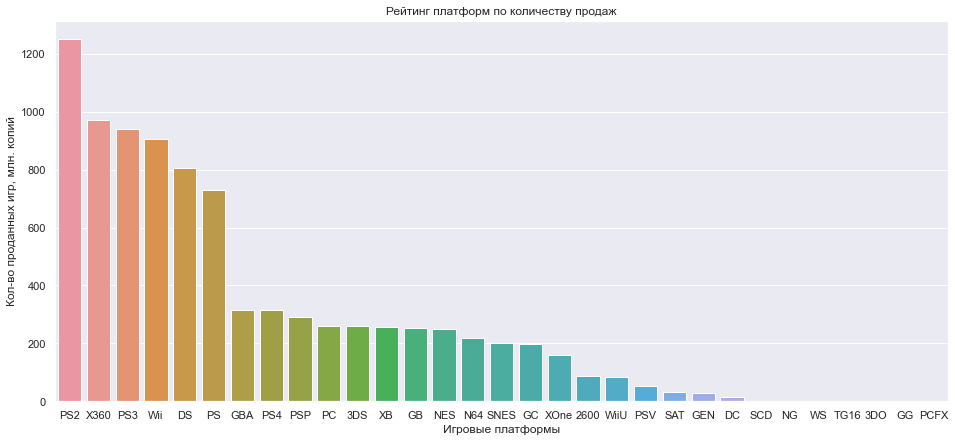

In [31]:
all_sales_platform = data.groupby('platform')['all_sales'].sum().sort_values(ascending=False).to_frame().reset_index()
display(all_sales_platform)

sns.set(rc = {'figure.figsize':(16,7)})
sns.barplot(data=all_sales_platform, x='platform', y='all_sales')
plt.title('Рейтинг платформ по количеству продаж')
plt.ylabel('Кол-во проданных игр, млн. копий')
plt.xlabel('Игровые платформы');

Явным лидером является **Play Station 2** (PS2), и помимо неё отчётливо выделяется **ещё 5** платформ (_в порядке убывания числа продаж_):
- XBox 360 (X360),
- Playstation 3 (PS3),
- Nintendo Wii (Wii),
- Nintendo DS (DS),
- Playstation 1 (PS).

Остальные платформы удобней рассмотреть отдельно на _тепловой диаграмме_:

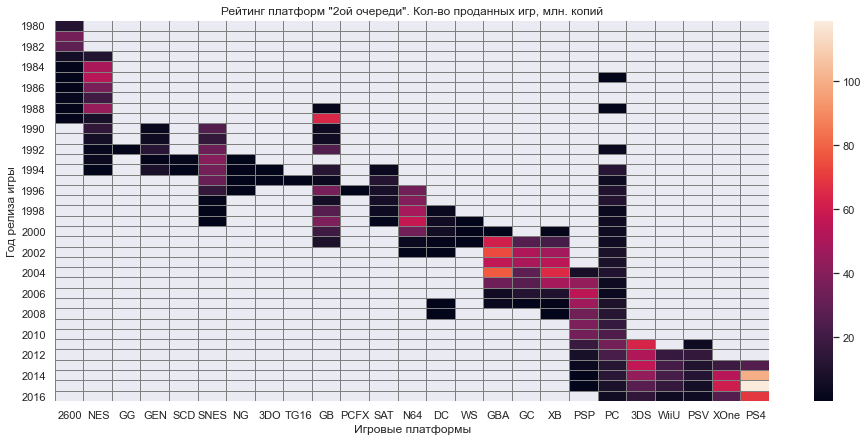

In [32]:
data_without_top_5 = data.loc[~data['platform'].isin(all_sales_platform.loc[0:5,'platform'].values),
                              ['platform', 'year_of_release', 'all_sales']]
sales_of_platforms = data_without_top_5.pivot_table(index='year_of_release',
                                                    columns='platform',
                                                    values='all_sales', 
                                                    aggfunc='sum')

# Изменить порядок столбцов, для визуального упрощения. Два рабочих способа:
# Автоматический. Он появился позже, потому что не сразу понял как его реализовать.
sales_of_platforms = sales_of_platforms.reindex(
    columns=data_without_top_5.groupby('platform')\
    ['year_of_release'].mean().sort_values().to_frame().reset_index()['platform'].unique())

sns.heatmap(sales_of_platforms, square=False, linewidth=.01, linecolor='grey')
plt.title('Рейтинг платформ "2ой очереди". Кол-во проданных игр, млн. копий')
plt.xlabel('Игровые платформы')
plt.ylabel('Год релиза игры');

В 80-ые годы существовал "дефицит" игровых платформ, что положило начало долгому и успешному существованию _Nintendo Entertainment System_ (NES) и _Game Boy_ (GB), в след за которыми стали появляться новые игровые жанры, и более совершенные платформы.

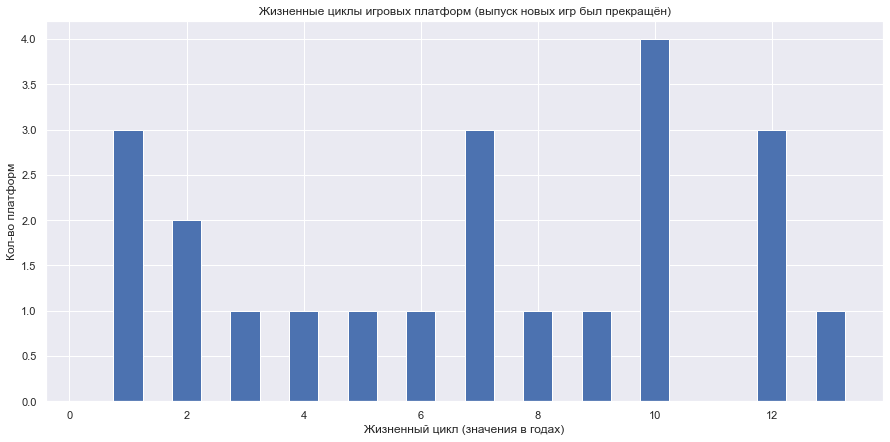

In [33]:
actual_platforms = data.loc[data['year_of_release'] == 2016, 'platform'].unique() #список актуальных платформ

platform_lives = data.loc[~data['year_of_release'].isna(), ['platform', 'year_of_release']]
platform_lives = platform_lives[~platform_lives['platform'].isin(actual_platforms)] #Исключение актуальных платформ
platform_lives = platform_lives.groupby('platform')['year_of_release'].unique().to_frame().reset_index()
platform_lives['years_of_live'] = 0

for i in range(platform_lives.shape[0]):
    platform_lives.loc[i, 'years_of_live'] = len(platform_lives.loc[i, 'year_of_release'])
platform_lives = platform_lives.sort_values(by='years_of_live')

platform_lives['years_of_live'].plot(kind='hist', bins=26, grid=True, legend=False, figsize=(15,7), range=(0.25, 13.25),
                    title='Жизненные циклы игровых платформ (выпуск новых игр был прекращён)')
plt.xlabel('Жизненный цикл (значения в годах)')
plt.ylabel('Кол-во платформ');

В среднем платформы живут 7-10 лет. Если платформе удаётся просуществовать первые 2 года - то её шансы на существования значительно увеличиваются.

На этом этапе была обнаружена **аномалия** для NINTENDO DS: "Возможно присутствуют выбросы за 1985 год, т.к. основной объём этих игр сконцентрирован за период 2004-2013 года". О ней шла речь на этапе предобработки.

## 3.3. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

В текущее время частота появления новых игр, едва ли, не выходит на первое месте, нежели частота появление новых платформ. Учитывая предыдущие результаты, актуальным периодом будут считаться последние ~3.5 года, начиная с 2013 года. В этот период попадает год выхода новых приставок _Хbox One_ и _Playstation 4_, от двух крупных конкурентов. Каждый год в этом периоде имеет сравнительно одинаковое количество выпущенных игр, что позволяет проводить сравнение в динамике.

In [34]:
actual_data = data[data['year_of_release'] >= 2013]
display(actual_data)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,<NA>,NaN,no_rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16701,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,no_rating,0.01
16705,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,<NA>,NaN,no_rating,0.01
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,no_rating,0.01
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,no_rating,0.01


## 3.4. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

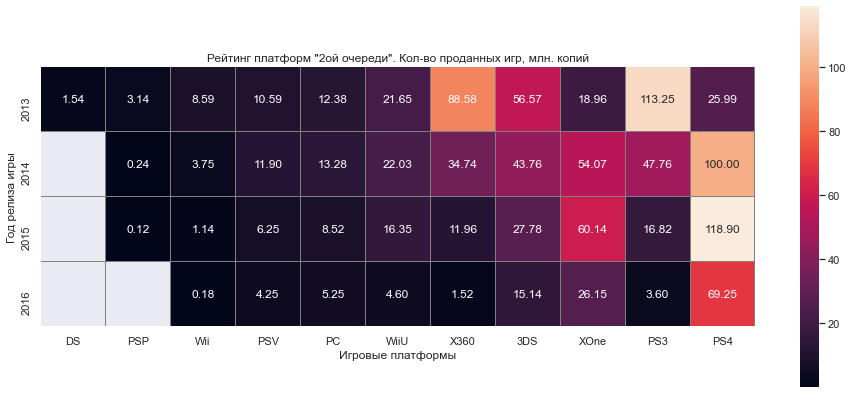

In [35]:
sales_of_actual_platforms = actual_data.pivot_table(index='year_of_release',
                                                    columns='platform',
                                                    values='all_sales',
                                                    aggfunc='sum')

#Изменить порядок столбцов, для визуального упрощения
sales_of_actual_platforms = sales_of_actual_platforms.reindex(columns = actual_data.groupby('platform')\
    ['all_sales'].sum().sort_values().to_frame().reset_index()['platform'].unique())

sns.heatmap(sales_of_actual_platforms, square=True, annot=True, fmt=".2f", linewidth=.01, linecolor='grey')
plt.title('Рейтинг платформ "2ой очереди". Кол-во проданных игр, млн. копий')
plt.xlabel('Игровые платформы')
plt.ylabel('Год релиза игры');

Среди лидеров две пары домашних консолей: `Xbox One` и её предшественник `Xbox 360` и вторая пара `Playstation 3 и 4`. В этот список попала портативная игровая консоль `3DS` от Nintendo, которая является последователем `Nintendo DS`, закончившая выпуск новых игр в 2013 году. Среди этих пар видим переходный процесс: продажи старой платформы - падают, а новых - возрастают. 

## 3.5. Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

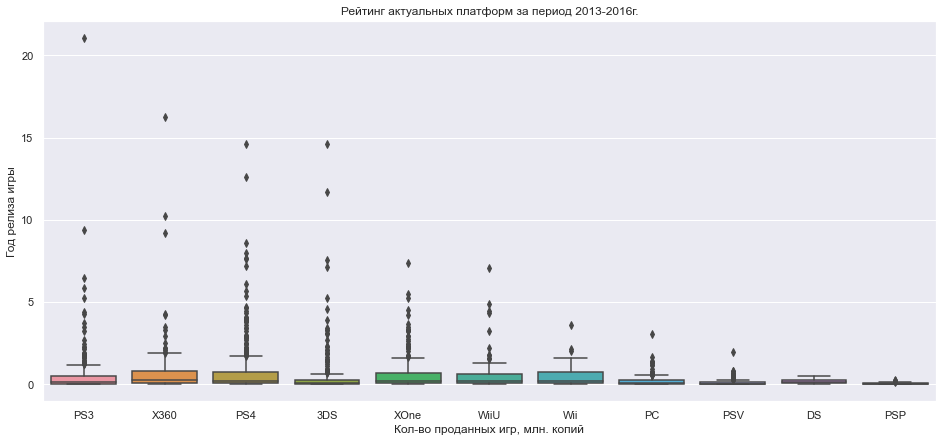

In [36]:
sns.boxplot(data=actual_data, x='platform', y='all_sales')
plt.title('Рейтинг актуальных платформ за период 2013-2016г.')  #UPD
plt.xlabel('Кол-во проданных игр, млн. копий')
plt.ylabel('Год релиза игры');

In [37]:
display(actual_data[actual_data['all_sales'] > 2]) #Бестселлеры около 5.5%

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,<NA>,NaN,no_rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
813,DriveClub,PS4,2014,Racing,0.36,1.38,0.02,0.31,71,6.1,E,2.07
828,Madden NFL 15,X360,2014,Sports,1.77,0.06,0.00,0.22,<NA>,5.5,E,2.05
846,Battlefield 4,XOne,2013,Shooter,1.25,0.58,0.00,0.19,81,6.6,M,2.02
849,Just Dance 2015,Wii,2014,Misc,0.99,0.85,0.00,0.17,<NA>,8.4,E10+,2.01


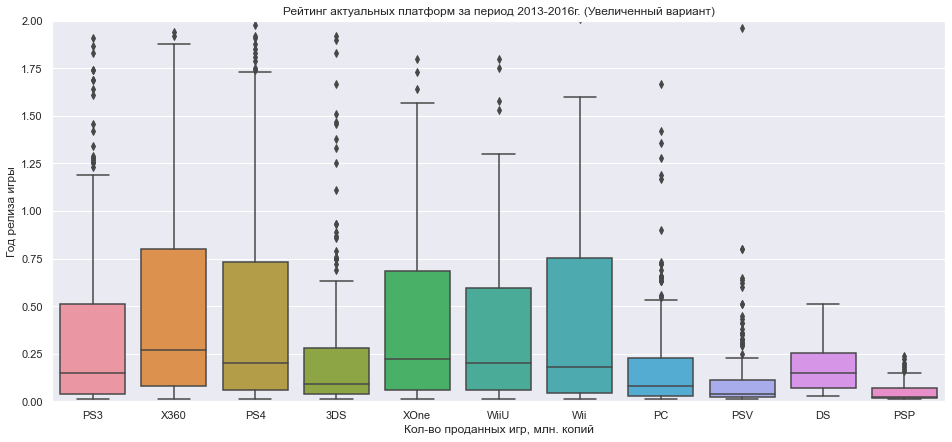

In [38]:
sns.boxplot(data=actual_data, x='platform', y='all_sales')
plt.title('Рейтинг актуальных платформ за период 2013-2016г. (Увеличенный вариант)')
plt.xlabel('Кол-во проданных игр, млн. копий')
plt.ylabel('Год релиза игры')
plt.ylim(0, 2);

На всех графиках, распределение **смещено вправо** - в сторону бОльшего количества продаж. За пределами 3-ого квартиля присутствуют **выбросы** - они же бестселлера. Эти игры расположены в диапазоне от 2-20 млн. продаж, а их доля среди общего числа актуальных игр составляет 5,5%.

Первые 5 платформ слева - лидеры, которые выбиваются в топ именно за счёт своих **бестселлеров**. Следствием этого является повышенное внимание к платформе и увеличенное количество продаж среди других игр.

## 3.6. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [39]:
a = actual_data.groupby('platform')['user_score'].count().sort_values(ascending=False).to_frame().reset_index()
b = actual_data.groupby('platform')['critic_score'].count().sort_values(ascending=False).to_frame().reset_index()

display(a.merge(b, how='outer'))

,platform,user_score,critic_score
0,PS4,263,252
1,PS3,209,121
2,XOne,193,169
3,PC,160,149
4,X360,153,81
5,PSV,106,77
6,3DS,105,71
7,WiiU,85,70
8,Wii,18,0
9,DS,6,0


### `Playstation 4`

- среди популярных платформ имеет **наибольшие выборки** по оценкам игроков и критиков. Её данные я возму за основу.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,no_rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,<NA>,NaN,no_rating,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17
143,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82,5.7,E,6.08


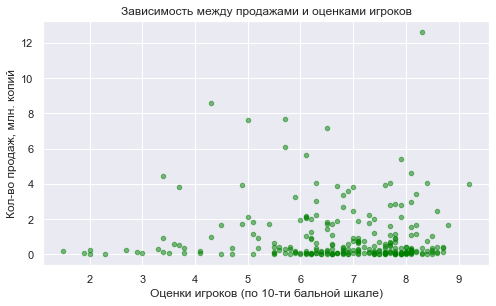

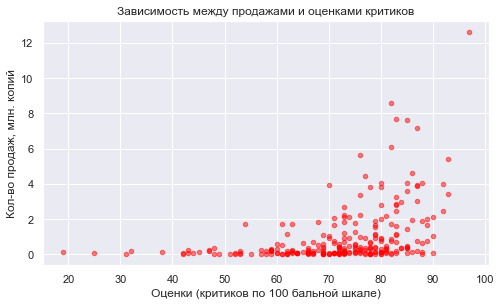

In [40]:
PS4_data = actual_data[actual_data['platform'] == 'PS4'] # отбираю игры Playstation 4 за актуальный период (2013-2016)
PS4_data = PS4_data[PS4_data['user_score'] != 'tbd']     # отбрасываю игры, оценка которых ещё не сформирована
PS4_data['user_score'] = PS4_data['user_score'].astype('float') #о ставшимся значениям присваиваю численный тип данных

#plt.subplot(121) # попытка разместить оба графика по горизонтали, для удобного обзора
PS4_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, color='green',
              xlabel='Оценки игроков (по 10-ти бальной шкале)', ylabel='Кол-во продаж, млн. копий',
              title='Зависимость между продажами и оценками игроков')

#plt.subplot(122)
PS4_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='red',
              xlabel='Оценки (критиков по 100 бальной шкале)', ylabel='Кол-во продаж, млн. копий',
              title='Зависимость между продажами и оценками критиков');

PS4_data[['user_score', 'critic_score', 'all_sales']].corr()

display(PS4_data[PS4_data['all_sales'] > 6]) # любопытный выброс

Хорошие оценки **критиков**, вцелом, положительно влияют на рост продаж, но зависимость между этими величинами слабая. У игр, получившие оценки 70 баллов и выше, резко увеличивается шанс стать бестселлером.

Среди оценок **игроков** вовсе отсутствует явная зависимость. К примеру: игры с продажими от 6 млн. копий. Только одна из них имеет 9,7/10 баллов. Оценки остальных лежат в диапазоне: 4,0 - 6,5 баллов. Большинство оценок находятся в диапазоне 5,4 - 8,8 баллов.

Вцелом, такой результат получается из-за **разного подхода** в оценке у игрока и критика. Среди пользователей имеет место быть "импульсивность" - поставить завышенную/заниженную оценку, опираясь на краткосрочный всплеск эмоций. Например, влепить минимальную оценку, т.к. игра не оправдала личные ожидания по сюжету, при этом не обратив внимание на техническую составляющую. Короче говоря: **объективность**.

### `Playstation 3`

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71,2.6,M,9.36
126,FIFA 14,PS3,2013,Sports,0.78,4.24,0.07,1.37,86,4.3,E,6.46
149,The Last of Us,PS3,2013,Action,2.41,2.18,0.28,0.99,95,9.1,M,5.86
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,<NA>,NaN,no_rating,5.27
255,Call of Duty: Advanced Warfare,PS3,2014,Shooter,1.56,1.93,0.19,0.68,<NA>,4.8,M,4.36
264,FIFA 15,PS3,2014,Sports,0.58,3.02,0.04,0.64,<NA>,4.5,E,4.28


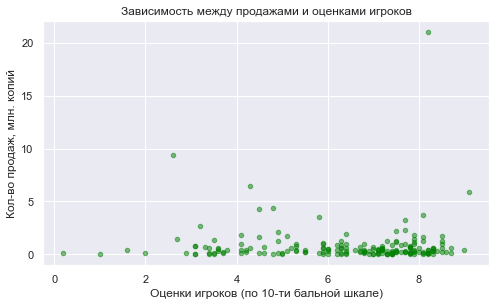

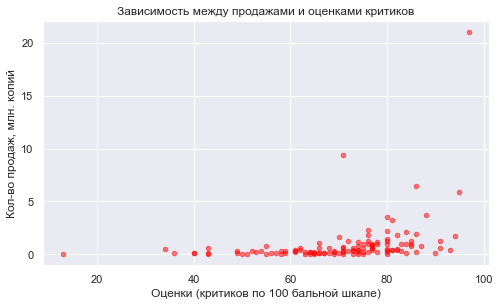

In [41]:
PS3_data = actual_data[actual_data['platform'] == 'PS3'] #отбираю игры Playstation 4 за актуальный период (2013-2016)
PS3_data = PS3_data[PS3_data['user_score'] != 'tbd'] #отбрасываю игры, оценка которых ещё не сформирована
PS3_data['user_score'] = PS3_data['user_score'].astype('float') #оставшимся значениям присваиваю численный тип данных

#plt.subplot(121) #попытка разместить оба графика по горизонтали, для удобного обзора
PS3_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, color='green',
              xlabel='Оценки игроков (по 10-ти бальной шкале)', ylabel='Кол-во продаж, млн. копий',
              title='Зависимость между продажами и оценками игроков')

#plt.subplot(122)
PS3_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='red',
              xlabel='Оценки (критиков по 100 бальной шкале)', ylabel='Кол-во продаж, млн. копий',
              title='Зависимость между продажами и оценками критиков');

PS3_data[['user_score', 'critic_score', 'all_sales']].corr()

display(PS3_data[PS3_data['all_sales'] > 4])

### `Xbox One`

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,<NA>,NaN,no_rating,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81,5.4,M,5.26
242,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84,6.4,T,4.49
270,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88,6.2,M,4.22


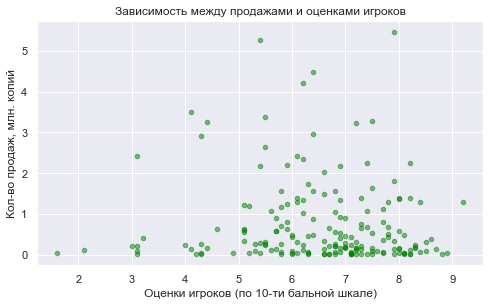

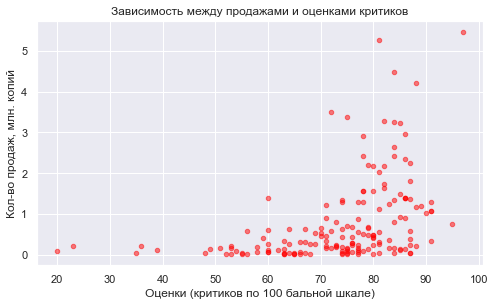

In [42]:
XOne_data = actual_data[actual_data['platform'] == 'XOne'] 
XOne_data = XOne_data[XOne_data['user_score'] != 'tbd'] 
XOne_data['user_score'] = XOne_data['user_score'].astype('float')

XOne_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='green',
               xlabel='Оценки игроков (по 10-ти бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками игроков')

XOne_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='red',
               xlabel='Оценки (критиков по 100 бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками критиков');

XOne_data[['user_score', 'critic_score', 'all_sales']].corr()

display(XOne_data[XOne_data['all_sales'] > 4])

### `Xbox 360`

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73,2.6,M,10.24
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,<NA>,NaN,no_rating,9.18
263,Call of Duty: Advanced Warfare,X360,2014,Shooter,2.77,1.11,0.00,0.40,<NA>,4.9,M,4.28
271,FIFA 14,X360,2013,Sports,0.92,2.89,0.01,0.40,84,4.2,E,4.22


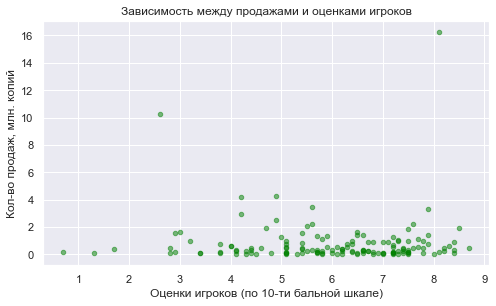

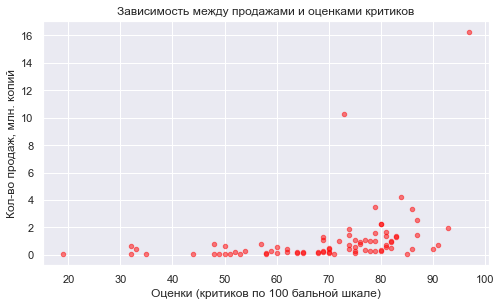

In [43]:
X360_data = actual_data[actual_data['platform'] == 'X360'] 
X360_data = X360_data[X360_data['user_score'] != 'tbd'] 
X360_data['user_score'] = X360_data['user_score'].astype('float')

X360_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='green',
               xlabel='Оценки игроков (по 10-ти бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками игроков')

X360_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='red',
               xlabel='Оценки (критиков по 100 бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками критиков');

X360_data[['user_score', 'critic_score', 'all_sales']].corr()

display(X360_data[X360_data['all_sales'] > 4])

### `PC`

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
458,The Sims 4,PC,2014,Simulation,1.00,1.82,0.0,0.23,70,3.9,T,3.05
1094,StarCraft II: Heart of the Swarm,PC,2013,Strategy,0.83,0.66,0.0,0.18,86,7.9,T,1.67
1350,SimCity (2013),PC,2013,Simulation,0.48,0.77,0.0,0.17,64,2.2,E10+,1.42
1436,Battlefield 4,PC,2013,Shooter,0.39,0.87,0.0,0.10,81,6.0,M,1.36
1529,Fallout 4,PC,2015,Role-Playing,0.51,0.67,0.0,0.10,84,5.4,M,1.28
1676,Farming Simulator 2015,PC,2014,Simulation,0.08,1.04,0.0,0.07,<NA>,NaN,no_rating,1.19
1729,Grand Theft Auto V,PC,2015,Action,0.39,0.69,0.0,0.09,96,7.9,M,1.17
2302,The Elder Scrolls Online,PC,2014,Role-Playing,0.32,0.51,0.0,0.07,71,5.7,M,0.90


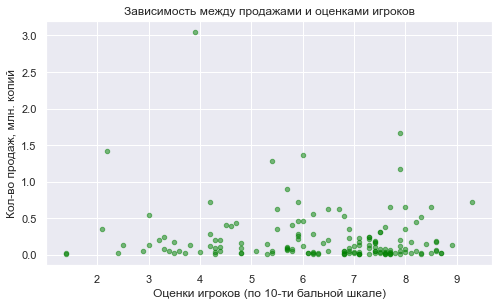

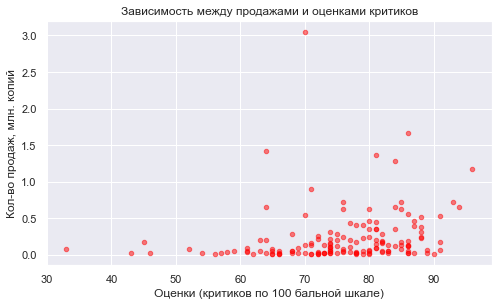

In [44]:
PC_data = actual_data[actual_data['platform'] == 'PC'] 
PC_data = PC_data[PC_data['user_score'] != 'tbd'] 
PC_data['user_score'] = PC_data['user_score'].astype('float')

PC_data.plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='green',
               xlabel='Оценки игроков (по 10-ти бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками игроков')

PC_data.plot(x='critic_score', y='all_sales', kind='scatter', alpha=0.5, figsize=(8, 4.5), grid=True, c='red',
               xlabel='Оценки (критиков по 100 бальной шкале)', ylabel='Кол-во продаж, млн. копий',
               title='Зависимость между продажами и оценками критиков');

PC_data[['user_score', 'critic_score', 'all_sales']].corr()

PC_data[PC_data['all_sales'] > 0.8]

## 3.7. Соотнесите выводы с продажами игр на других платформах.

Хорошие оценки критиков, вцелом, положительно влияют на рост продаж, но зависимость между этими величинами слабая. Наибольшая явная зависимоть у новых консолей `Playstation 4` и `Xbox One` (~0.40), наименее явняя у `PC` (0.19). Возможная зависимость имеет не линейную форму, а экспоненциальную. Резкий рост продаж начинается с оценок 70-80 баллов.

Среди **оценок игроков** вовсе отсутствует явная зависимость. Коэф. корреляции принимает значения близкие к нулю. Но заметно, что на консолях предыдущего поколения `Playstation 3` и `Xbox 360` значительно меньше бестселлеров, за исключением новых игр, которые были адаптированы и для старых игровых приставок. То небольшое количество флагманских игр продолжают увеличивать миллионные продажи, и продлевают срок актуальности этих платформ. Самая малочисленная по числу продаж - `PC`, которая отличается в несколько раз.

Среди **игровых приставок** преобладают жары: `Shooter`, `Sports` и `Action`.
Платформы `PC` сильно отличается в этом плане: `Simulation` и `Role-Playing`.


## 3.8. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

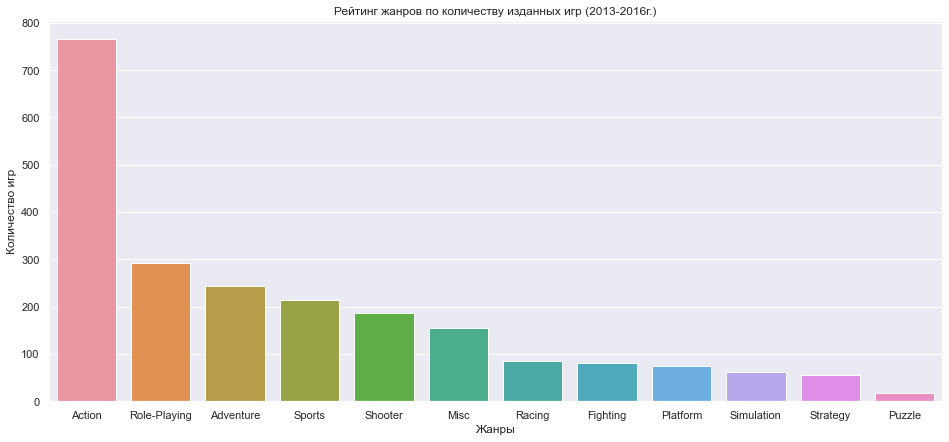

In [45]:
sns.barplot(data = actual_data.groupby('genre')['name'].count().sort_values(ascending=False).to_frame().reset_index(),
            x='genre', y='name')
plt.title('Рейтинг жанров по количеству изданных игр (2013-2016г.)')
plt.ylabel('Количество игр')
plt.xlabel('Жанры');

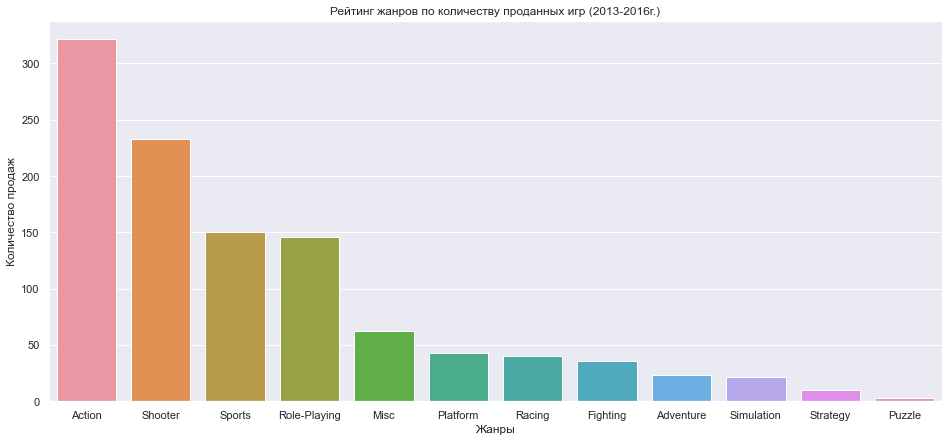

In [46]:
sns.barplot(data = actual_data.groupby('genre')['all_sales'].sum().sort_values(ascending=False).to_frame().reset_index(),
            x='genre', y='all_sales')
plt.title('Рейтинг жанров по количеству проданных игр (2013-2016г.)');
plt.ylabel('Количество продаж')
plt.xlabel('Жанры');

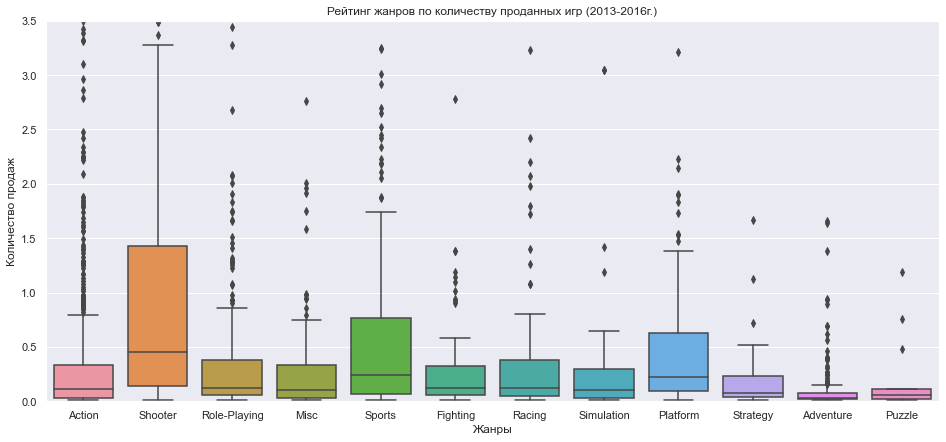

In [47]:
# UPD
sns.boxplot(data = actual_data, x='genre', y='all_sales')
plt.title('Рейтинг жанров по количеству проданных игр (2013-2016г.)')
plt.ylabel('Количество продаж')
plt.xlabel('Жанры')
plt.ylim(0, 3.5);

- Самый популярный жанр: `Action`.  В нём огромное количество игр, большая конкуренция, но прибыльные в нём - еденичные экземпляры.
- Самым прибыльным жанром можно считать: `Shooter`'ы

- 2-ой по продажам: `Sports`, хотя по количеству игр занимает 4ое место. Возможно, в этом жанре ещё не успела сформироваться жесткая конкуренция и есть свободные места.

- Аналогичная ситуация для `Platform`, занимающий 3е место по медианным доходам. Правда в лидерах - ветераны этого жанра.

- Остальные жанры имеют схожие средние показатели, кроме совсем малочисленных жанров: `Adventure` и `Puzzle`.

In [48]:
actual_data.query('genre == "Platform"').head() #UPD

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
260,Super Mario 3D World,WiiU,2013,Platform,2.11,1.16,0.73,0.32,93,9,E,4.32
424,Super Mario Maker,WiiU,2015,Platform,1.18,0.89,0.94,0.20,88,8.7,E,3.21
719,New Super Luigi U,WiiU,2013,Platform,1.25,0.62,0.18,0.18,77,7.9,E,2.23
765,Skylanders SWAP Force,Wii,2013,Platform,1.21,0.75,0.00,0.19,<NA>,6.6,E10+,2.15
907,LittleBigPlanet 3,PS4,2014,Platform,0.66,0.93,0.01,0.31,79,7.1,E,1.91


<a id='section_4'></a> 
# 4. Портет игрока для каждого региона

Определить для пользователя каждого региона (`NA`, `EU`, `JP`):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

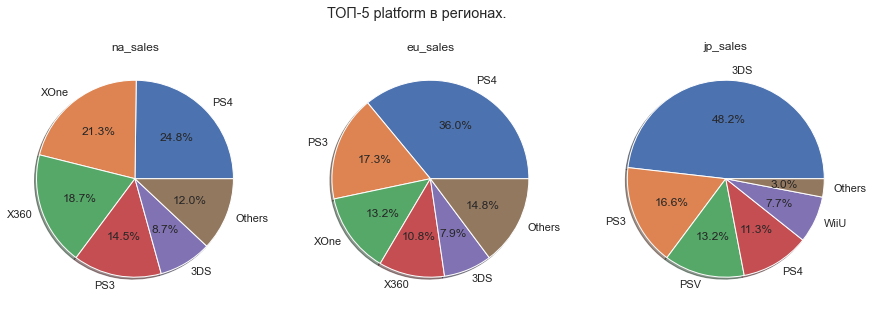

,platform_na,na_sales,part_na,platform_eu,eu_sales,part_eu,platform_jp,jp_sales,part_jp
pos,,,,,,,,,
1,PS4,108.74,24.8,PS4,141.09,36.0,3DS,67.81,48.2
2,XOne,93.12,21.3,PS3,67.81,17.3,PS3,23.35,16.6
3,X360,81.66,18.7,XOne,51.59,13.2,PSV,18.59,13.2
4,PS3,63.50,14.5,X360,42.52,10.8,PS4,15.96,11.3
5,3DS,38.20,8.7,3DS,30.96,7.9,WiiU,10.88,7.7
6,Others,52.49,12.0,Others,58.26,14.8,Others,4.19,3.0


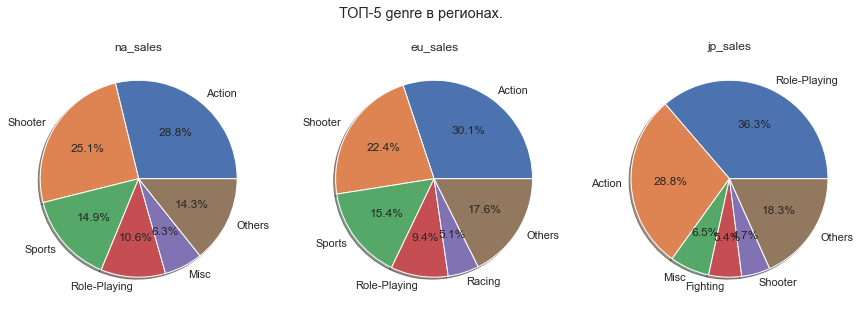

,genre_na,na_sales,part_na,genre_eu,eu_sales,part_eu,genre_jp,jp_sales,part_jp
pos,,,,,,,,,
1,Action,126.07,28.8,Action,118.13,30.1,Role-Playing,51.04,36.3
2,Shooter,109.74,25.1,Shooter,87.86,22.4,Action,40.49,28.8
3,Sports,65.27,14.9,Sports,60.52,15.4,Misc,9.20,6.5
4,Role-Playing,46.40,10.6,Role-Playing,36.97,9.4,Fighting,7.65,5.4
5,Misc,27.49,6.3,Racing,20.19,5.1,Shooter,6.61,4.7
6,Others,62.74,14.3,Others,68.56,17.6,Others,25.79,18.3


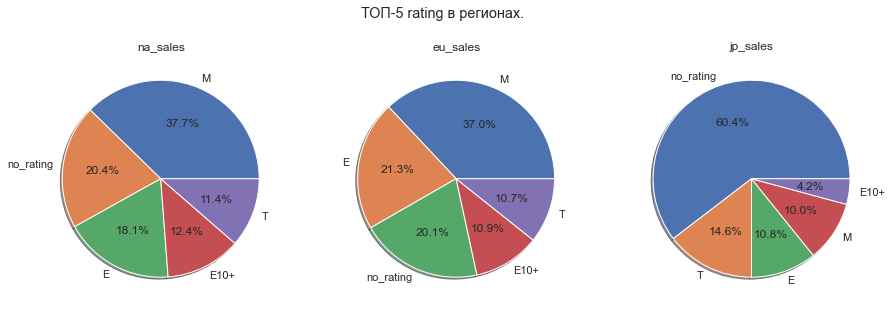

,rating_na,na_sales,part_na,rating_eu,eu_sales,part_eu,rating_jp,jp_sales,part_jp
pos,,,,,,,,,
1,M,165.21,37.7,M,145.32,37.0,no_rating,85.05,60.4
2,no_rating,89.40,20.4,E,83.36,21.3,T,20.59,14.6
3,E,79.05,18.1,no_rating,78.91,20.1,E,15.14,10.8
4,E10+,54.26,12.4,E10+,42.69,10.9,M,14.11,10.0
5,T,49.79,11.4,T,41.95,10.7,E10+,5.89,4.2


In [49]:
for col in ['platform', 'genre', 'rating']: #Критерии оценивания
    p_table = pd.DataFrame({'pos':[1, 2, 3, 4, 5, 6]}) # 'pos' - position
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # создание пространства для графиков: одна строка, три столбца.
    fig.suptitle('ТОП-5 '+ col +' в регионах.')
    for sale, i in zip(['na_sales', 'eu_sales', 'jp_sales'], [0, 1, 2]): #Регионы оценивания
        top_5 = actual_data.groupby(col)[sale].sum().sort_values(ascending=False).to_frame().reset_index() 
        top_5['part'] = round(top_5[sale] / sum(top_5[sale]) * 100, 1)
        if col in ['platform', 'genre']:
            top_5.loc[5, col] = 'Others'
            top_5.loc[5, sale] = sum(top_5.loc[5:, sale])
            top_5.loc[5, 'part'] = 100 - sum(top_5.loc[0:4, 'part'])
            top_5 = top_5[:6]
        
        axs[i].pie(data=top_5, x='part', labels=col, autopct='%1.1f%%', shadow=True)
        axs[i].set_title(sale)
        p_table = p_table.merge(top_5, how='outer', left_index=True, right_index=True, suffixes=('_na', '_eu'))
    plt.show()
    
    p_table.rename(columns={'platform':'platform_jp', 'genre':'genre_jp', 'rating':'rating_jp', 'part':'part_jp'}, inplace=True)
    p_table.set_index('pos', inplace=True)
    if col == 'rating':
        p_table.drop(index = 6, inplace=True)
    display(p_table) #Сводная таблица по критериям
    print('\n')

## 4.1. Портрет `NA` игрока

Для 40% игроков Северной Америки типична **приставка** от `Xbox (One/360)` - они в тройке лидеров, хотя первое место занимает новая приставка `Playstation 4`. Предыдущее поколение `PS3` теряет конкурентоспособность. `Nintendo 3DS` - замыкает топ.

Явные лидеры **жанров**: `Action` и `Shooter` - 29% и 25%, соответственно. Далее (в порядке равномерного убывания доли продаж): `Sports`, `Role-Playing` и `Music`.

Больше трети (37,7%) продаваемых игр в Северной Америке предназначены для **взрослых** от 17 лет. Треть - это игры для подростков разного возроста. И 20% приходится на игры без рейтинга.

## 4.2. Портрет `EU` игрока

На территории Европы те же лидеры среди **приставок**. Правда `Playstation 3 и 4` является подавляющим большинством, т.к. на эту платформу приходится около 53% игр. `Xbox One и 360`, суммарно, занимают не более _четверти_ от общего числа.

В контексте игровых **жанров**, сохранился тот же порядок лидеров, но с небольшим отличиям. На жанр `Action` приходится 30% игр и он лидирует со значительным отрывом от `Shooter`'ов (22%). Линейку "ТОП 5 жанров" замыкает `Racing`, в отличии от `Misc` в Сев. Америке.

**Возростной рейтинг** игр - аналогный.

## 4.3. Портрет `JP` игрока

Япония имеет координальные отличия. Абсолютный лидер среди **платформ**: `Nintendo 3DS`. Около _половины_ продаваемых игр доступны на этой портативной консоле. А домашная консоль `WiiU` от той же Nintendo, не пользуется схожей популярностью. Чуть больше _четверти_ игр приходится другую домашнуюе приставку: `Playstation 4 и 3`, кстати, последняя ещё сохраняет лидерство, над своим новым поколением. От этого же производителя есть популярная "карманная" консоль `Playstation Vita` - 13%.

Лидеры **жанров**: `Role-Playing` и `Action` - 36% и 29%, соответственно. На оставшиеся жанры в среднем приходится не более 5-6% игр.

Большенство игр (60%) не имеют возрастных рейтинга. Остальные категории занимают от 5 до 15%. Возрастной рейтинг в этом регионе не имеет особого значения.

<a id='section_5'></a> 
# 5. Проверка гипотез

## 5.1. Средние пользовательские рейтинги платформ Xbox One и PC - одинаковые

Необходимо сформулировать нулевую гипотезу (как правило, это утверждение о равенстве) и альтернативную гипотезу, которая примется за верную, в случае отвержения предыдущей.
- Нулевая гипотеза (**H0**): Средние оценки пользователей на платформ `Xbox One` и `PC` - равны.
- Альтер. гипотеза (**H1**): Средния оценка пользователей `Xbox One` выше, чем у пользователей `PC`.

Необходимо провести проверку гипотезы о равенстве средних двух выборок, с помощью t-теста. Предварительно осмотрев исходные данные.
- Выборки **независимы** друг от друга.
- Количество оценок пользователей _PC_ на 15% меньше чем у _Xbox One_. Дисперсии - **разные**.

,user_score
count,182.000000
mean,6.521429
std,1.380941
min,1.600000
25%,5.800000
50%,6.800000
75%,7.500000
max,9.200000


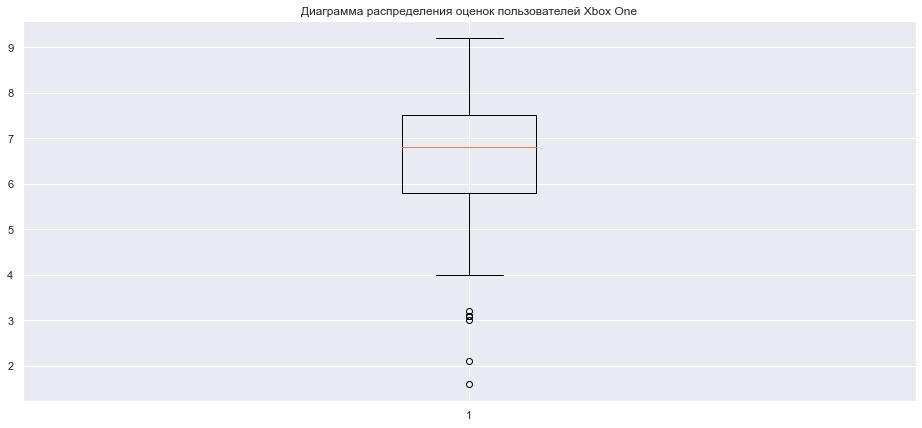

In [57]:
XOne_score = actual_data.loc[actual_data['platform'] == 'XOne', 'user_score']
XOne_score = XOne_score[(XOne_score != 'tbd') & (~XOne_score.isna())]
XOne_score = XOne_score.astype('float')
display(XOne_score.describe().to_frame())
plt.boxplot(XOne_score)
plt.title('Диаграмма распределения оценок пользователей Xbox One');

,user_score
count,155.000000
mean,6.269677
std,1.742381
min,1.400000
25%,5.300000
50%,6.800000
75%,7.600000
max,9.300000


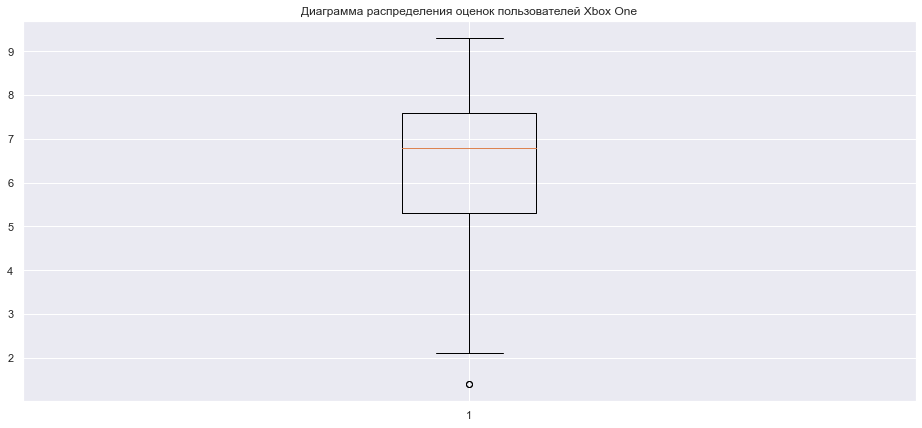

In [58]:
PC_score = actual_data.loc[actual_data['platform'] == 'PC', 'user_score']
PC_score = PC_score[(PC_score != 'tbd') & (~PC_score.isna())]
PC_score = PC_score.astype('float')
display(PC_score.describe().to_frame())
plt.boxplot(PC_score)
plt.title('Диаграмма распределения оценок пользователей Xbox One');

In [52]:
alpha = 0.05
results = st.ttest_ind(list(XOne_score), list(PC_score), equal_var=False)

print('p-значение:', round(results.pvalue, 2))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15
Не получилось отвергнуть нулевую гипотезу


Если трактовать результат дословно, то: с вероятностью **15%** можно получить _этот же (или более далёкий)_ результат, если считать, что нулевая гипотеза верна.

## 5.2. Средние пользовательские рейтинги жанров Action и Sports - разные

Здесь применяется аналогичный метод проверки.
- Нулевая гипотеза (**H0**): Средние оценки игр для жанров `Action` и `Sports` - равны.
- Альтер. гипотеза (**H1**): Средние оценки игр для жанров `Action` и `Sports` - разные.

Необходимо провести проверку гипотезы о равенстве средних двух выборок, с помощью t-теста. Предварительно осмотрев исходные данные.
- Выборки **независимы** друг от друга.
- Выборки сильно отличаются по количеству. Дисперсии - **разные**.

,user_score
count,389.000000
mean,6.837532
std,1.330173
min,2.000000
25%,6.300000
50%,7.100000
75%,7.800000
max,9.100000


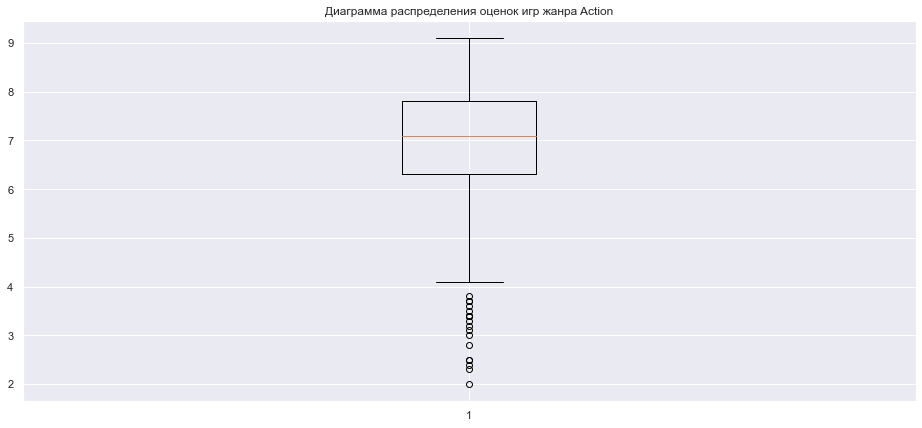

In [59]:
action_score = actual_data.loc[actual_data['genre'] == 'Action', 'user_score']
action_score = action_score[(action_score != 'tbd') & (~action_score.isna())]
action_score = action_score.astype('float')

display(action_score.describe().to_frame())
plt.boxplot(action_score)
plt.title('Диаграмма распределения оценок игр жанра Action');

,user_score
count,160.000000
mean,5.238125
std,1.783427
min,0.200000
25%,4.100000
50%,5.500000
75%,6.500000
max,8.800000


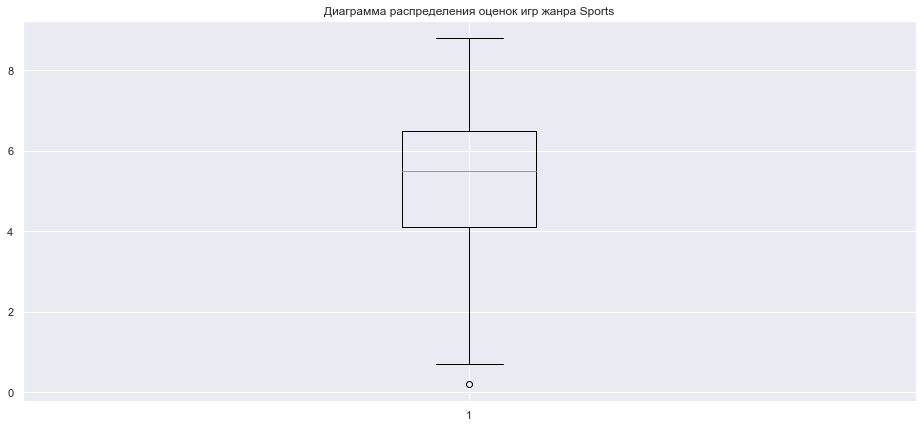

In [61]:
sports_score = actual_data.loc[actual_data['genre'] == 'Sports', 'user_score']
sports_score = sports_score[(sports_score != 'tbd') & (~sports_score.isna())]
sports_score = sports_score.astype('float')
#print(sports_score.unique())

display(sports_score.describe().to_frame())
plt.boxplot(sports_score)
plt.title('Диаграмма распределения оценок игр жанра Sports');

In [55]:
alpha = 0.05
results = st.ttest_ind(list(action_score), list(sports_score), equal_var=False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Результат**: Крайне мала вероятность того, что средние пользовательские оценки для игр `Action` и `Sports` - равны. При уровне статистической значимости: 5%. Это позволяет отвергнуть нулевую гипотезу в пользу верности альтернативной гипотезы.

<a id='section_6'></a> 
# 6. Общий вывод

Если **успех игры** исчислять количеством проданных копий, то основные параметры влияющия на объём продаж это:
- _жанр_,
- _платформа_,
- _возрастной рейтинг_,
- на их основе можно определить _территорию_ наиболее востребовательных пользователей.

Сумарно, по эти 4-ём параметрам, можно подсчитать ожидаемый диапазон продаж.

**Например**:
- `Shooter` с возростным рейтингом `Mature`(17+) для домашних консолей `Playstation 4` - прибыльный вариант для территории **Европы**. Аналогичный вариант подойдёт **Сев. Америки**, с дополнительным каналом рекламы: `Xbox One`. Эта приставка одинакова популярка как PS4.
- `Role-Playing` или `Action` исключительно для портативной консоли `Nintendo 3DS`, возростное ограничение ESRB не имеет значение - верный вариант для Японии.

При выборе можно учесть отзыв критиков. Желательно, чтобы оценка была от 70 баллов. Рейтинг пользователей - нельзя расценивать однозначно.

В перечень параметров игр можно **добавить**:
- дату релиза,
- стоимость игры (на момент выпуска),
Если эти данные уже есть, то при следующем исследовании стоит выгрузить их. Это позволит определить успех игр с финансовой стороны.